In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import os
import pandas as pd
import torch
import math
from datasets import Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, Trainer

import matplotlib as plt
import seaborn as sns
sns.set_theme()

In [3]:
gpuids = [0, 1, 2, 3]

if gpuids is None or len(gpuids) == 0:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    print("Using CPU")
else:
    gpuid_str = str(gpuids[0])
    for gpuid in gpuids[1:]:
        gpuid_str += ",{}".format(gpuid)
    os.environ["CUDA_VISIBLE_DEVICES"] = gpuid_str
    print("Using GPU:{}".format(gpuid_str))

Using GPU:0,1,2,3


In [4]:
import torch
torch.cuda.is_available()

True

In [6]:
df_list = []
for data_path in data_args["data_files"]:
    df = pd.read_csv(data_path)
    df.drop(columns="Unnamed: 0", inplace=True)
    df_list.append(df)
data_df = pd.concat(df_list)
if data_args["data_split"] is not None:
    data_df = data_df[data_df["data_split"] == data_args["data_split"]]

In [8]:
dataset = Dataset.from_pandas(data_df)

In [9]:
tokenizer_kwargs = {
    "use_fast": model_args["use_fast_tokenizer"],
    "cache_dir": model_args["cache_dir"]
}

tokenizer = AutoTokenizer.from_pretrained(model_args["tokenizer_name"], **tokenizer_kwargs)

In [14]:
def tokenize_func(examples):
    return tokenizer(
        examples["text"],
        padding=False,  # do dynamic padding to longest sequence in batch later
        truncation=True,
        # We use this option because DataCollatorForLanguageModeling (see below) is more efficient when it
        # receives the `special_tokens_mask`.
        return_special_tokens_mask=True
    )

In [15]:
tokenized_dataset = dataset.map(
    tokenize_func,
    batched=True,
    num_proc=data_args["preprocessing_num_workers"]
)

In [16]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=data_args["mlm_probability"],
)

## Things that need to be rerun for new checkpoints

In [27]:
checkpoint_num = 46000

In [28]:
model_args = {
    "model_name_or_path": "/data/ddmg/personalizedmentalhealth/reddit_project/reddit-personalized-lm/notebooks/tmp_trainer/checkpoint-{}/pytorch_model.bin".format(checkpoint_num),
    "tokenizer_name": "bert-base-uncased",
    "cache_dir": "/data/ddmg/personalizedmentalhealth/reddit_project/cached_models",
    "use_fast_tokenizer": True,
    "config_name_or_path": "/data/ddmg/personalizedmentalhealth/reddit_project/reddit-personalized-lm/notebooks/tmp_trainer/checkpoint-{}/config.json".format(checkpoint_num),
}

data_args = {
    "data_files": ["/data/ddmg/personalizedmentalhealth/reddit_project/data/4_all_data.csv"],
    "preprocessing_num_workers": None,  # number of processes to use for the preprocessing
    "mlm_probability": 0.15,  # ratio of tokens to mask for MLM loss
    "max_eval_samples": None,  # for debugging purposes, truncate # of evaluation samples to this value if set,
    "data_split": "val",  # evaluate just on this split of data (or all data if None)
}

In [29]:
config_kwargs = {
    "cache_dir": model_args["cache_dir"]
}

config = AutoConfig.from_pretrained(model_args["config_name_or_path"])

In [30]:
model = AutoModelForMaskedLM.from_pretrained(
    model_args["model_name_or_path"],
    config=config,
    cache_dir=model_args["cache_dir"]
)

In [31]:
trainer = Trainer(
    model=model,
    eval_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [32]:
metrics = trainer.evaluate()
max_eval_samples = data_args["max_eval_samples"] if data_args["max_eval_samples"] is not None else len(dataset)
metrics["eval_samples"] = min(max_eval_samples, len(dataset))
try:
    perplexity = math.exp(metrics["eval_loss"])
except OverflowError:
    perplexity = float("inf")
metrics["perplexity"] = perplexity
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [33]:
metrics

{'eval_loss': 1.4987913370132446,
 'eval_runtime': 93.1571,
 'eval_samples_per_second': 77.568,
 'eval_samples': 7226,
 'perplexity': 4.476275490896192}

## Plotting Results

In [34]:
def get_checkpoint_results(checkpoint_num):
    model_args = {
        "model_name_or_path": "/data/ddmg/personalizedmentalhealth/reddit_project/reddit-personalized-lm/notebooks/tmp_trainer/checkpoint-{}/pytorch_model.bin".format(checkpoint_num),
        "tokenizer_name": "bert-base-uncased",
        "cache_dir": "/data/ddmg/personalizedmentalhealth/reddit_project/cached_models",
        "use_fast_tokenizer": True,
        "config_name_or_path": "/data/ddmg/personalizedmentalhealth/reddit_project/reddit-personalized-lm/notebooks/tmp_trainer/checkpoint-{}/config.json".format(checkpoint_num),
    }

    data_args = {
        "data_files": ["/data/ddmg/personalizedmentalhealth/reddit_project/data/4_all_data.csv"],
        "preprocessing_num_workers": None,  # number of processes to use for the preprocessing
        "mlm_probability": 0.15,  # ratio of tokens to mask for MLM loss
        "max_eval_samples": None,  # for debugging purposes, truncate # of evaluation samples to this value if set,
        "data_split": "val",  # evaluate just on this split of data (or all data if None)
    }
    config_kwargs = {
        "cache_dir": model_args["cache_dir"]
    }

    config = AutoConfig.from_pretrained(model_args["config_name_or_path"])
    model = AutoModelForMaskedLM.from_pretrained(
        model_args["model_name_or_path"],
        config=config,
        cache_dir=model_args["cache_dir"]
    )
    trainer = Trainer(
        model=model,
        eval_dataset=tokenized_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator
    )
    metrics = trainer.evaluate()
    max_eval_samples = data_args["max_eval_samples"] if data_args["max_eval_samples"] is not None else len(dataset)
    metrics["eval_samples"] = min(max_eval_samples, len(dataset))
    try:
        perplexity = math.exp(metrics["eval_loss"])
    except OverflowError:
        perplexity = float("inf")
    metrics["perplexity"] = perplexity
    trainer.log_metrics("eval", metrics)
    trainer.save_metrics("eval", metrics)
    return perplexity

In [37]:
checkpoint_nums = os.listdir("/data/ddmg/personalizedmentalhealth/reddit_project/reddit-personalized-lm/notebooks/tmp_trainer")
checkpoint_nums = [x.split('-')[1] for x in checkpoint_nums if "checkpoint" in x]

In [40]:
checkpoint_nums = [int(x) for x in checkpoint_nums]
checkpoint_nums = sorted(checkpoint_nums)

In [41]:
len(checkpoint_nums)

49

In [42]:
perplexities = []
steps = []
for i in range(0, 50, 5):
    checkpoint_num = checkpoint_nums[i]
    steps.append(checkpoint_num)
    eval_perplexity = get_checkpoint_results(checkpoint_num)
    perplexities.append(eval_perplexity)

In [43]:
perplexities

[7.769476957891647,
 5.890491205788494,
 5.559376326304406,
 4.695809131828352,
 4.653905375228195,
 4.634502254431302,
 4.57620462610829,
 4.556685986827448,
 4.514396033478065,
 4.490805307891601]

<AxesSubplot:>

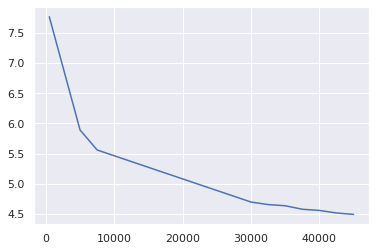

In [46]:
sns.lineplot(x=steps, y=perplexities)

In [ ]:
# get train historys